[View in Colaboratory](https://colab.research.google.com/github/kvm108/TrainingMaterial/blob/master/Pretrained_on_flower.ipynb)

In [1]:
! ls

sample_data


In [2]:
! git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 21658 (delta 0), reused 0 (delta 0), pack-reused 21652
Receiving objects: 100% (21658/21658), 559.41 MiB | 30.30 MiB/s, done.
Resolving deltas: 100% (12712/12712), done.
Checking out files: 100% (2809/2809), done.


In [3]:
% cd models/research/slim

/content/models/research/slim


In [4]:
! ls

BUILD				nets
datasets			preprocessing
deployment			README.md
download_and_convert_data.py	scripts
eval_image_classifier.py	setup.py
export_inference_graph.py	slim_walkthrough.ipynb
export_inference_graph_test.py	train_image_classifier.py
__init__.py			WORKSPACE


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

In [6]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir) 

>> Downloading flowers.tar.gz 100.0%
Successfully downloaded flowers.tar.gz 228649660 bytes.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


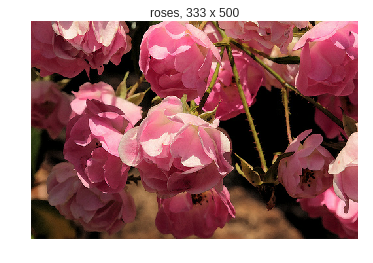

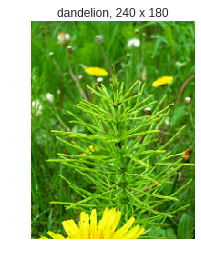

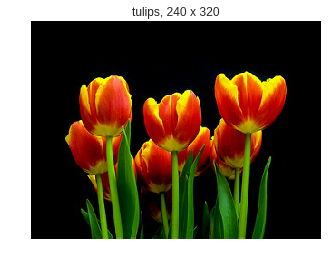

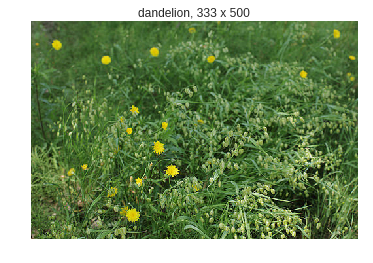

In [7]:
from datasets import flowers
import tensorflow as tf

from tensorflow.contrib import slim

#TODO : Change to tf.data

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

In [8]:
# Download the Inception V1 checkpoint

from datasets import dataset_utils

url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'

# "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v3_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v3_2016_08_28.tar.gz 100885009 bytes.


In [9]:
! ls /tmp/checkpoints/

inception_v3_2016_08_28.tar.gz	inception_v3.ckpt


In [0]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [16]:
# Note that this may take several minutes.

import os

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v3.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                break
        else:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inceptionv3_finetuned_001/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=500)
    
#     # Choose the metrics to compute:
#     names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
#         "accuracy": slim.metrics.accuracy(predictions, labels),
#         "mse": slim.metrics.mean_squared_error(predictions, labels),
#     })
    
#     # Define the summaries to write:
#     for metric_name, metric_value in metrics_to_values.iteritems():
#       tf.summary.scalar(metric_name, metric_value
                        
   
        
  
print('Finished training. Last batch loss %f' % final_loss)

INFO:tensorflow:Restoring parameters from /tmp/inceptionv3_finetuned_001/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/inceptionv3_finetuned_001/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 500.
INFO:tensorflow:global step 500: loss = 0.4782 (6.200 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 0.478217


In [17]:
! ls /tmp/inceptionv3_finetuned_001/

checkpoint				     model.ckpt-456.index
events.out.tfevents.1538989399.d3f7e35d5837  model.ckpt-456.meta
events.out.tfevents.1538991067.d3f7e35d5837  model.ckpt-500.data-00000-of-00001
graph.pbtxt				     model.ckpt-500.index
model.ckpt-0.data-00000-of-00001	     model.ckpt-500.meta
model.ckpt-0.index			     model.ckpt-501.data-00000-of-00001
model.ckpt-0.meta			     model.ckpt-501.index
model.ckpt-456.data-00000-of-00001	     model.ckpt-501.meta


In [18]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path='/tmp/inceptionv3_finetuned_001/' \
    --dataset_dir=/tmp/flowers \
    --dataset_name=flowers \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating /tmp/inceptionv3_finetuned_001/model.ckpt-501
INFO:tensorflow:Starting evaluation at 2018-10-08-09:31:40
INFO:tensorflow:Graph was finalized.
2018-10-08 09:31:40.836210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning N

In [32]:
! python eval_image_classifier.py --checkpoint_path=/tmp/inceptionv3_finetuned_001_1/ \
--eval_dir=eval_inceptionv3_finetuned_001_1 --dataset_name=flowers --dataset_dir=/tmp/flowers \
--model_name=inception_v3 --dataset_split_name=validation

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating /tmp/inceptionv3_finetuned_001_1/model.ckpt-5000
INFO:tensorflow:Starting evaluation at 2018-10-07-16:55:49
INFO:tensorflow:Graph was finalized.
2018-10-07 16:55:50.543320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [13]:
! cat eval_image_classifier.py

# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Generic evaluation script that evaluates a model using a given dataset."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import tensorflow as tf

from datasets import dataset_factory
from nets import nets_factory
from preprocessing imp

Instructions for updating:
Use `tf.local_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-2000


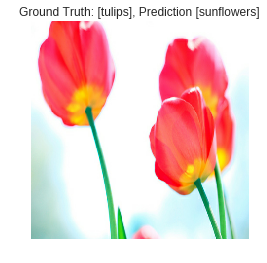

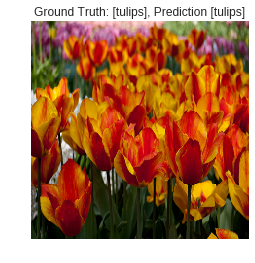

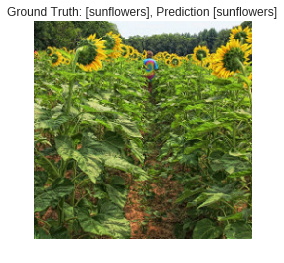

In [11]:
import numpy as np
import tensorflow as tf
from datasets import flowers
from nets import inception

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size
batch_size = 3

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()